# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

import datetime
from scipy.io import loadmat
from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


In [2]:

def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pred_dataset, pred_capacity = load_data('B0006')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


In [3]:

attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(10))
print('tail------')
print(dis_ele.tail(10))

pred_dis_ele = pred_capacity[attrib]
pred_C = pred_dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    pred_dis_ele['SoH']=(pred_dis_ele['capacity'])/pred_C
print(pred_dis_ele.head(10))

C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

pred_C = pred_dataset['capacity'][0]
pred_soh = []
for i in range(len(pred_dataset)):
  pred_soh.append([pred_dataset['capacity'][i] / C])
pred_soh = pd.DataFrame(data=pred_soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
train_datasetpd=pd.DataFrame(train_dataset)
print('--------')
print(train_datasetpd.head())
print(train_dataset.shape)
print(soh.shape)


attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
pred_train_dataset = pred_dataset[attribs]
pred_sc = MinMaxScaler(feature_range=(0,1))
pred_train_dataset = sc.fit_transform(pred_train_dataset)
pred_train_datasetpd=pd.DataFrame(pred_train_dataset)
print('-------')
print(pred_train_datasetpd.head())

print('---------')
print(train_datasetpd.shape)
print(pred_train_datasetpd.shape)
print(soh.shape)
print(pred_soh.shape)

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235
5      6 2008-04-03 12:55:10  1.835662  0.988782
6      7 2008-04-03 17:17:16  1.835146  0.988504
7      8 2008-04-03 21:28:14  1.825757  0.983447
8      9 2008-04-04 01:38:15  1.824774  0.982917
9     10 2008-04-04 05:48:08  1.824613  0.982831
tail------
     cycle            datetime  capacity       SoH
158    159 2008-05-25 10:51:37  1.303033  0.701881
159    160 2008-05-25 15:37:08  1.303357  0.702056
160    161 2008-05-25 20:23:04  1.303410  0.702084
161    162 2008-05-26 01:13:02  1.297887  0.699109
162    163 2008-05-26 06:01:08  1.298074  0.699209
163    164 2008-05-26 10:44:38  1.293464  0.696726
164    165 2008-05-26 15:30:43  1.288003  0.693785
165    166 2008-05-26 20:21:04  1.287453  

(50285, 7)


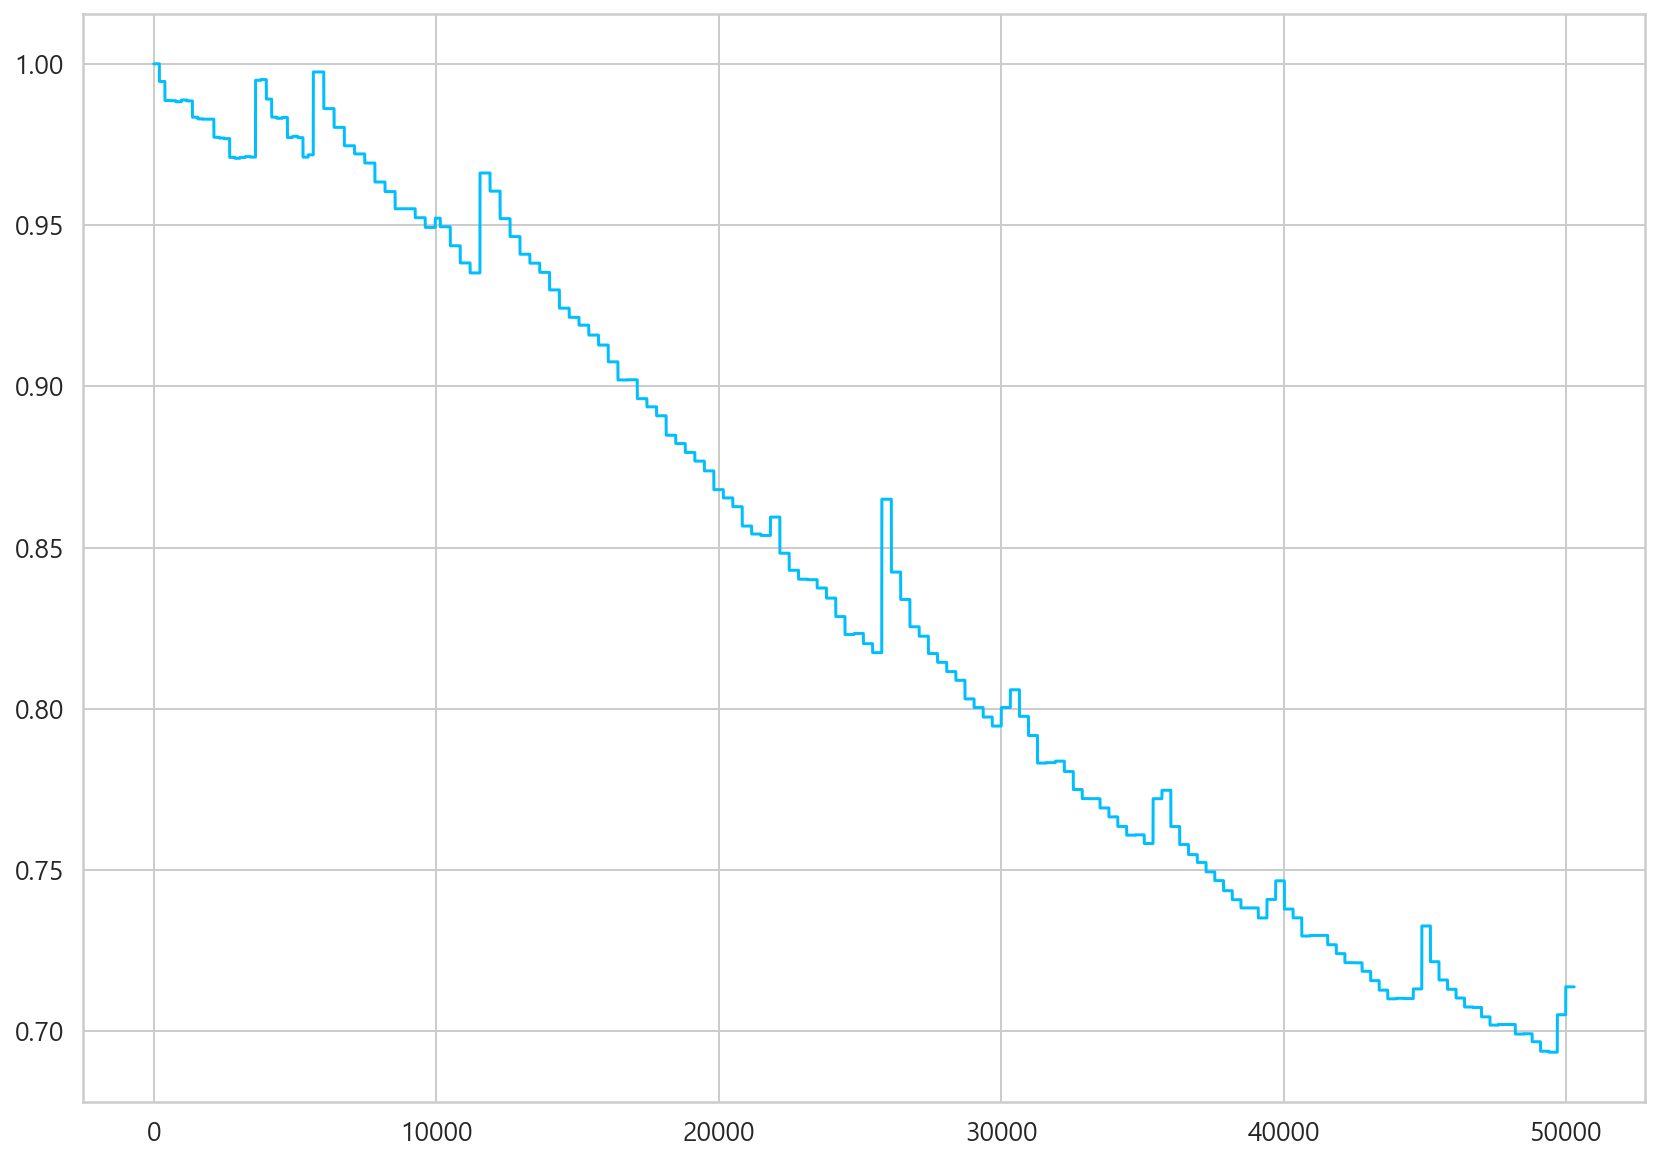

In [4]:
'''
test_data_size = 30

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]
'''
#sohs = ['time']
y_train = soh
y_test = pred_soh

X_train = train_datasetpd
X_test = pred_train_datasetpd

print(X_train.shape)
plt.plot(y_train)
plt.show()

In [5]:
#X_cols = list(df.columns)
#X_cols.remove('target')


In [6]:
'''
# 테스트 데이터 수
test_data_size = 20
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']
'''

"\n# 테스트 데이터 수\ntest_data_size = 20\n# X변수들과 y변수 구분\nX = df[X_cols]\ny = df['target']\n"

In [7]:
'''
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()
'''

'\n# MinMaxScaler을 통한 스케일링\nscaler = MinMaxScaler()\n# X scaler 생성\nXscaler = scaler.fit(X)\n# Y scaler 생성\nyscaler = scaler.fit(y.values.reshape(-1,1))\n\n# 스케일링 적용\nX = Xscaler.transform(X)\ny = yscaler.transform(y.values.reshape(-1,1))\n\n# Train, Test set split\nX_train, X_test = X[:-test_data_size], X[-test_data_size:]\ny_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()\n'

In [8]:
X_train = np.array(X_train)
y_train= np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (50285, 7)
test set :  (50285, 7)


In [9]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [10]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [11]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [12]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([50285, 1, 7])
X_test : torch.Size([50285, 1, 7])
y_train : torch.Size([50285, 1, 1])
y_test : torch.Size([50285, 1, 1])


# Building a Model

In [13]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [14]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [15]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=20

In [ ]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.7316 test loss: 0.7056


In [ ]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [24]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [25]:
preds

[0.09392260760068893,
 0.09613301604986191,
 0.09745749086141586,
 0.09999293833971024,
 0.10412495583295822,
 0.10926834493875504,
 0.1127251461148262,
 0.11753223091363907,
 0.12108879536390305,
 0.12279243022203445,
 0.12046333402395248,
 0.1168404147028923,
 0.11270789057016373,
 0.10805243998765945,
 0.10492820292711258,
 0.10291152447462082,
 0.10033533722162247,
 0.09733026474714279,
 0.09489233046770096,
 0.09210283309221268]

In [26]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [27]:
pred_values

array([[6.01104689],
       [6.15251303],
       [6.23727942],
       [6.39954805],
       [6.66399717],
       [6.99317408],
       [7.21440935],
       [7.52206278],
       [7.7496829 ],
       [7.85871553],
       [7.70965338],
       [7.47778654],
       [7.213305  ],
       [6.91535616],
       [6.71540499],
       [6.58633757],
       [6.42146158],
       [6.22913694],
       [6.07310915],
       [5.89458132]])

In [28]:
pred_values_ceiled  = list(pred_values.flatten())

In [29]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [30]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [31]:
score_table

,True,Pred
0,12.0,6.011047
1,16.0,6.152513
2,10.0,6.237279
3,5.0,6.399548
4,8.0,6.663997
5,5.0,6.993174
6,6.0,7.214409
7,4.0,7.522063
8,2.0,7.749683
9,4.0,7.858716


In [32]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [33]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 14.338641726753076, RMSE : 3.7866398992712624, SCORE : 78.29123129938974


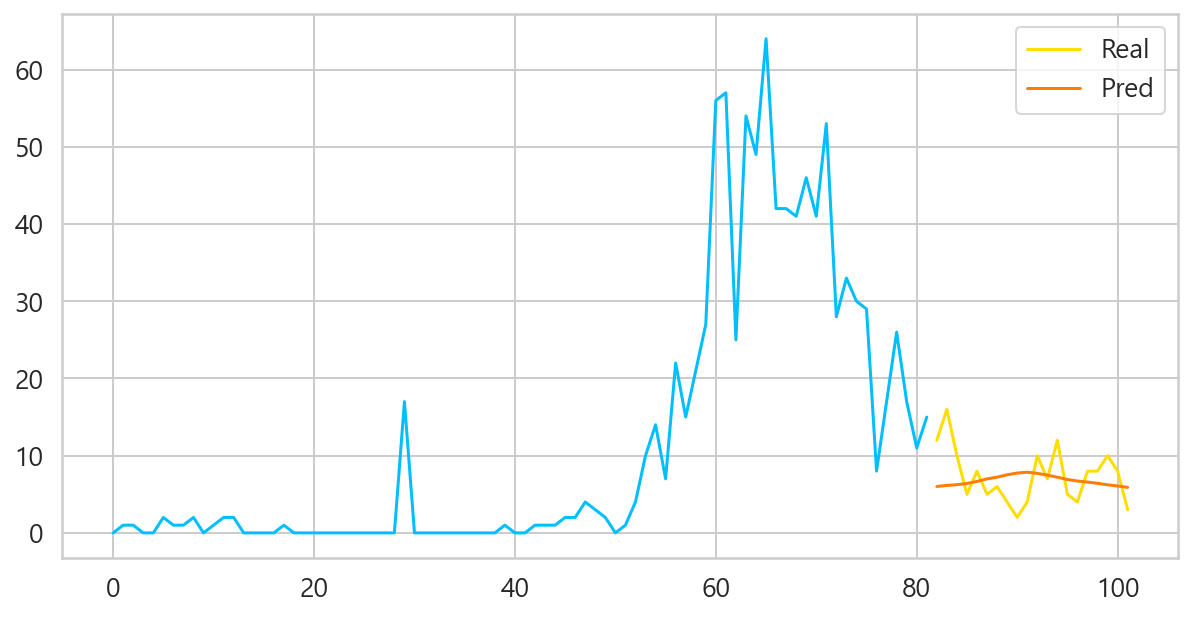

In [34]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [76]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [77]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [78]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [79]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [80]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [81]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [82]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [83]:
# model = CoronaVirusPredictor(
#   n_features=n_features,
#   n_hidden=n_hidden,
#   seq_len=seq_length,
#   n_layers=n_layers
# )
# model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

# Predicting future cases

In [84]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [85]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [86]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[8.542214393615723,
 8.863585472106934,
 9.061980247497559,
 9.157882690429688,
 9.19661808013916,
 9.203207969665527,
 9.236523628234863,
 9.317728996276855,
 9.421761512756348,
 9.520094871520996,
 9.591507911682129,
 9.62355899810791,
 9.612334251403809,
 9.541833877563477]

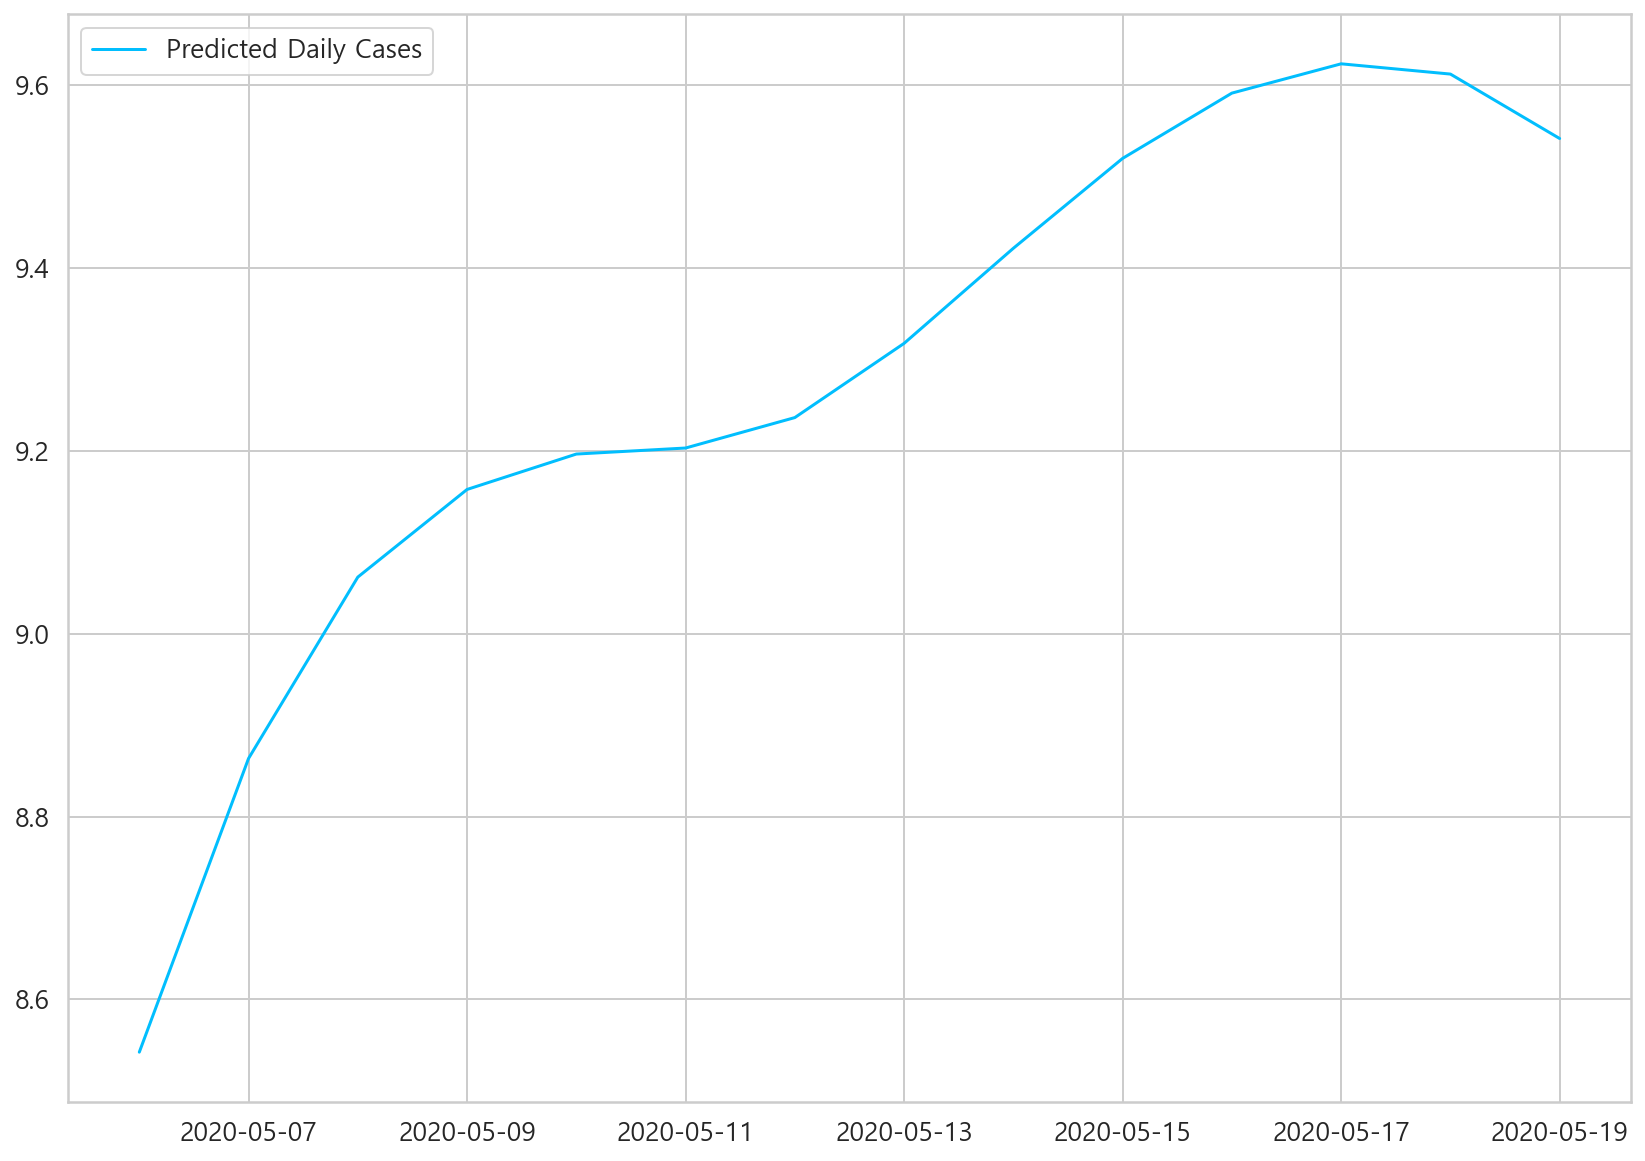

In [87]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [88]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [89]:
preds_

,0
2020-05-06,8.542214
2020-05-07,8.863585
2020-05-08,9.061980
2020-05-09,9.157883
2020-05-10,9.196618
2020-05-11,9.203208
2020-05-12,9.236524
2020-05-13,9.317729
2020-05-14,9.421762
2020-05-15,9.520095


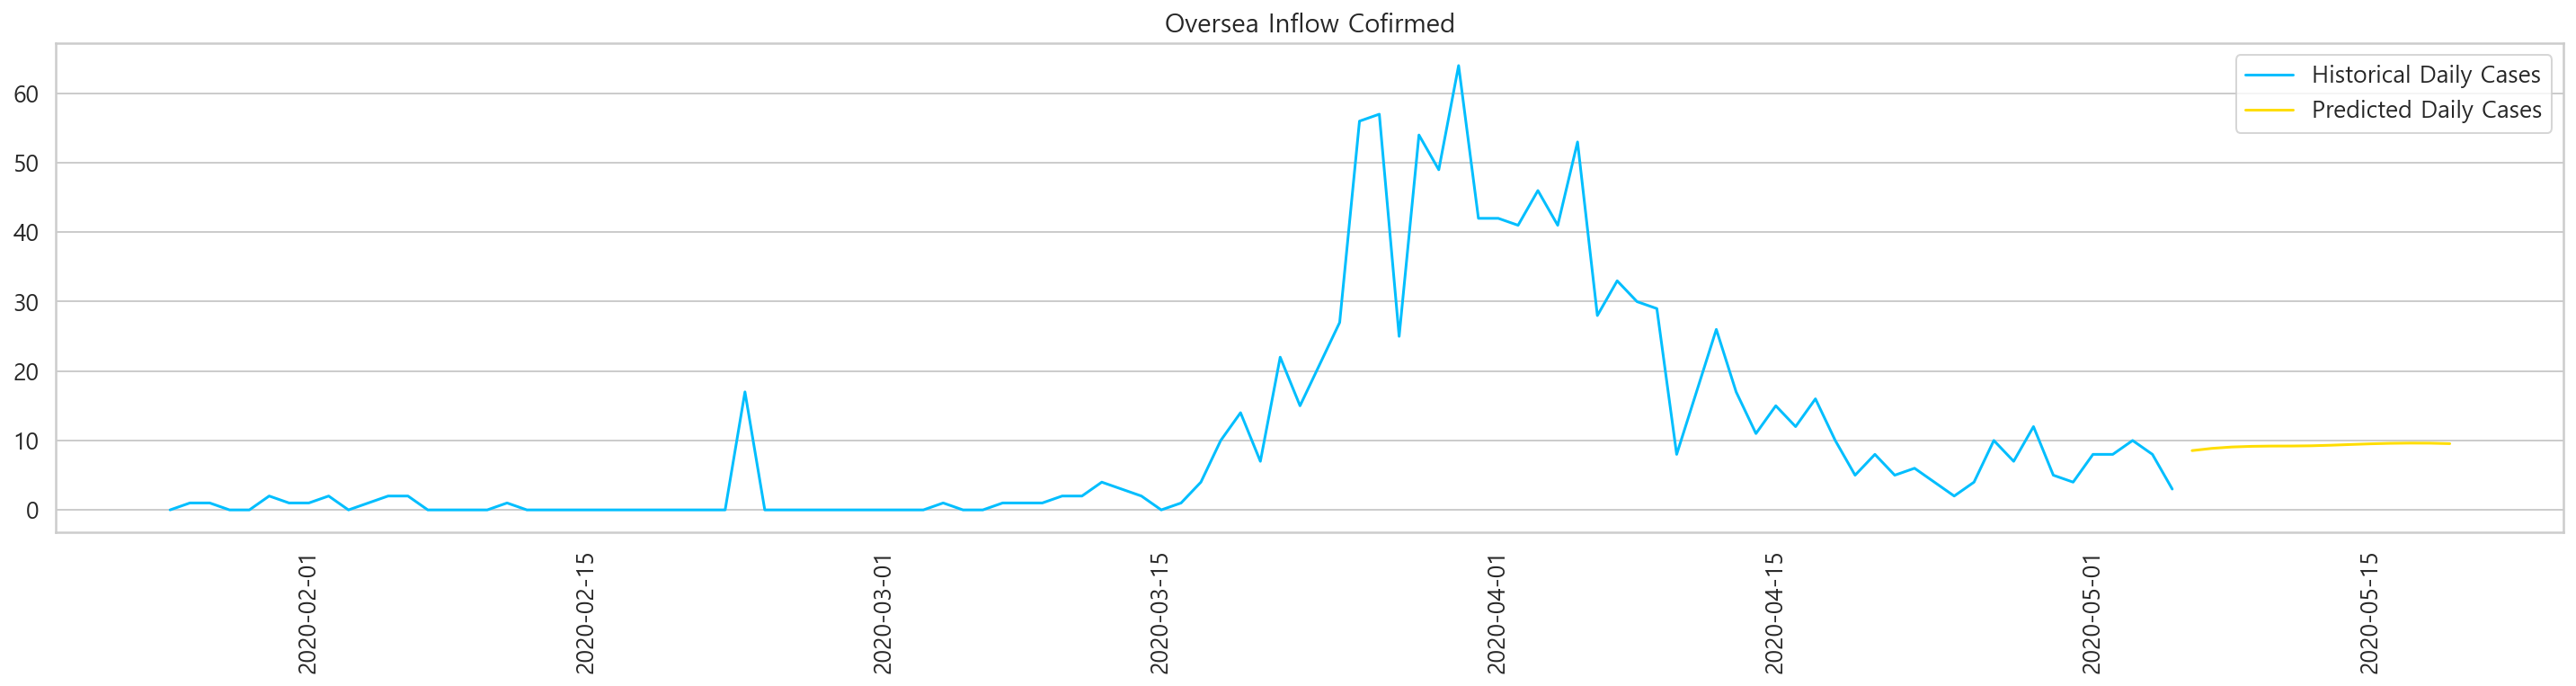

In [90]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();